# Comparer des classificateurs

Dans la [feuille précédente](3_extraction_d_attributs.md), nous avons
observé que les performances pouvaient varier selon le niveau de
prétraitement des données (données brutes, données nettoyées,
extractions d'attributs, etc.). Cependant, l'analyse de performance
n'a été conduite qu'avec un seul classificateur (plus proches
voisins).

Il est posssible que chaque classificateur donne des résultats
différents pour un niveau de pré-traitement donné.

Dans cette feuille, on étudie les performances selon le type de
classificateur. Les étapes seront:
1. Déclarer et entraîner les différents classificateurs sur nos
   données;
2. Visualiser les performances de chaque classificateur;
3. Comprendre et identifier le sous-apprentisssage et le
   surapprentissage;
4. **Pour aller plus loin ♣**: Étudier un comité de classificateurs et
   l'incertitude dans les données;
5. **Pour aller plus loin ♣**: Apprentissage profond et transfert
   d'apprentissage.

## Entraînement des différents classificateurs

### Import des bibliothèques

In [1]:
import os, re
from glob import glob as ls
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns; sns.set()
from PIL import Image
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
from sys import path

from utilities import *
from intro_science_donnees import data
from intro_science_donnees import *

### Import des données

Nous chargeons les images prétraitées dans la feuille précédente :

In [2]:
dataset_dir = 'data'

images = load_images(dataset_dir, "*.jpg")
os.makedirs('clean_data', exist_ok=True)
for name, img in images.items():
    img.save(os.path.join('clean_data', os.path.splitext(name)[0]+".png"))
dataset_dir = 'clean_data'

images = load_images(dataset_dir, "*.png")

In [3]:
images[15] = images[15].crop(box=(5, 60, 250, 115))
images[16] = images[16].crop(box=(10, 30, 250, 160))
images[17] = images[17].crop(box=(20, 55, 220, 155))
images[18] = images[18].crop(box=(80, 65, 160, 110))
images[19] = images[19].crop(box=(50, 50, 220, 130))
images[20] = images[20].crop(box=(40, 100, 140, 145))
images[21] = images[21].crop(box=(20, 50, 160, 130))
images[22] = images[22].crop(box=(10, 60, 240, 140))
images[23] = images[23].crop(box=(10, 35, 260, 100))
images[24]= images[24].crop(box=(10, 30, 170, 80))
images[25] = images[25].crop(box=(50, 60, 210, 120))
images[26] = images[26].crop(box=(20, 40, 230, 90))
images[27] = images[27].crop(box=(20, 30, 240, 125))
images[28] = images[28].crop(box=(50, 40, 240, 120))
images[29] = images[29].crop(box=(10, 50, 240, 100))
images[0]=images[0].crop(box=(60,90,170,140))
images[1]=images[1].crop(box=(20,50,230,150))
images[2]=images[2].crop(box=(70,30,240,80))
images[3]=images[3].crop(box=(140,40,230,80))
images[4] = images[4].crop(box=(5, 40, 250, 130))
images[5] = images[5].crop(box=(4, 25, 260, 105))
images[6] = images[6].crop(box=(5, 40, 240, 120))
images[7] = images[7].crop(box=(40, 50, 220, 130))
images[8] = images[8].crop(box=(10, 30, 260, 90))
images[9] = images[9].crop(box=(20, 45, 210, 160))
images[10] = images[10].crop(box=(130, 45, 220, 80))
images[11] = images[11].crop(box=(5, 40, 240, 110))
images[12] = images[12].crop(box=(40, 20, 255, 70))
images[13] = images[13].crop(box=(20, 45, 230, 150))
images[14] = images[14].crop(box=(30, 80, 150, 120))

Vérifions l'import en affichant les 20 premières images :

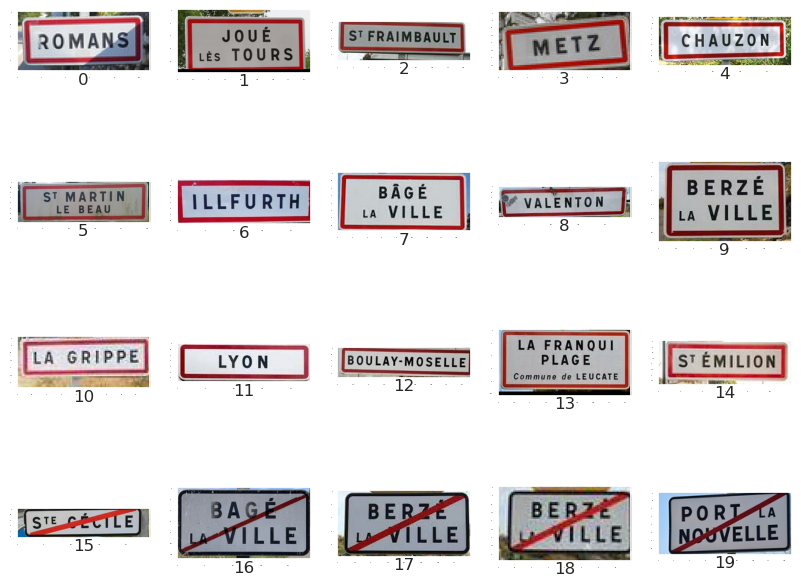

In [4]:
image_grid(images[:20])

Pour mettre en œuvre des classificateurs, nous pouvons repartir des
attributs extraits dans la fiche précédente :

In [5]:
df_features = pd.read_csv('features_data.csv', index_col=0)
df_features

,R-(G+B)/2,redness,R-G,B-R,blueness,class
a01.png,-0.819458,-0.645765,-0.645765,0.960591,0.960591,1
a02.png,0.832998,0.639565,0.639565,-0.993589,-0.993589,1
a03.png,-1.165473,-1.115796,-1.115796,1.165857,1.165857,1
a04.png,0.434927,0.307214,0.307214,-0.545896,-0.545896,1
a05.png,1.045996,0.502187,0.502187,-1.553118,-1.553118,1
a06.png,-1.140912,-1.074046,-1.074046,1.159798,1.159798,1
a07.png,1.874201,2.373534,2.373534,-1.286833,-1.286833,1
a08.png,0.996458,1.272453,1.272453,-0.673498,-0.673498,1
a09.png,0.441118,0.504101,0.504101,-0.358240,-0.358240,1
a10.png,0.742239,0.570631,0.570631,-0.884571,-0.884571,1


On vérifie que nos données sont normalisées :

In [6]:
df_features.describe()

,R-(G+B)/2,redness,R-G,B-R,blueness,class
count,3.000000e+01,30.000000,3.000000e+01,3.000000e+01,3.000000e+01,30.000000
mean,1.646831e-16,0.000000,-1.406282e-16,1.868875e-16,1.572816e-17,0.000000
std,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.017095
min,-1.827938e+00,-1.577183,-1.577183e+00,-1.774193e+00,-1.774193e+00,-1.000000
25%,-8.027422e-01,-0.705673,-7.056728e-01,-8.435474e-01,-8.435474e-01,-1.000000
50%,-3.256111e-01,-0.393332,-3.933323e-01,1.613008e-01,1.613008e-01,0.000000
75%,8.103084e-01,0.559597,5.595971e-01,7.609927e-01,7.609927e-01,1.000000
max,1.898727e+00,2.373534,2.373534e+00,2.003995e+00,2.003995e+00,1.000000


### Déclaration des classificateurs

Nous allons à présent importer les classificateurs depuis la librairie
`scikit-learn`. Pour cela, on stockera:
- les noms des classificateurs dans la variable `model_name`;
- les classificateurs eux-mêmes dans la variable `model_list`.

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

model_name = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
model_list = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

La bibliothèque `scikit-learn` nous simplifie la tâche : bien que les
classificateurs aient des fonctionnements très différents, leurs
interfaces sont identiques (rappelez vous la notion d'encapsulation
vue dans le cours «Programmation Modulaire»). Les méthodes sont:
- `.fit` pour entraîner le classificateur sur des données
  d'entraînement;
- `.predict` pour prédire des étiquettes sur les données de test;
- `.predict_proba` pour obtenir des prédictions sur les données de
  test sous forme de probabilités sur les classes;
- `.score` pour calculer la performance du classificateur.

## Visualisation des performances des classificateurs

Nous allons à présent faire des tests systématiques sur cet ensemble
de données (attributs de l'analyse de variance univiarié). La fonction
`systematic_model_experiment(data_df, model_name, model_list,
sklearn_metric)` permet de réaliser ces tests systématiques:

In [9]:
from sklearn.metrics import balanced_accuracy_score as sklearn_metric
compar_results = systematic_model_experiment(df_features, model_name, model_list, sklearn_metric)
compar_results.style.set_precision(2).background_gradient(cmap='Blues')

,perf_tr,std_tr,perf_te,std_te
Nearest Neighbors,0.92,0.03,0.84,0.07
Linear SVM,0.86,0.07,0.88,0.05
RBF SVM,0.97,0.03,0.79,0.09
Gaussian Process,0.96,0.05,0.80,0.10
Decision Tree,1.00,0.00,0.83,0.10
Random Forest,0.99,0.03,0.84,0.08
Neural Net,0.89,0.05,0.85,0.05
AdaBoost,1.00,0.00,0.84,0.09
Naive Bayes,0.86,0.07,0.83,0.04
QDA,0.90,0.12,0.69,0.12


**Exercice:** Quelle méthode obtient les meilleures performances de
test? La méthode permettant d'obtenir les meilleures performances de test est Random forest

In [10]:
model_list[compar_results.perf_te.argmax()]

SVC(C=0.025, kernel='linear', probability=True)

On peut également représenter les performances dans un graphique en
barres:

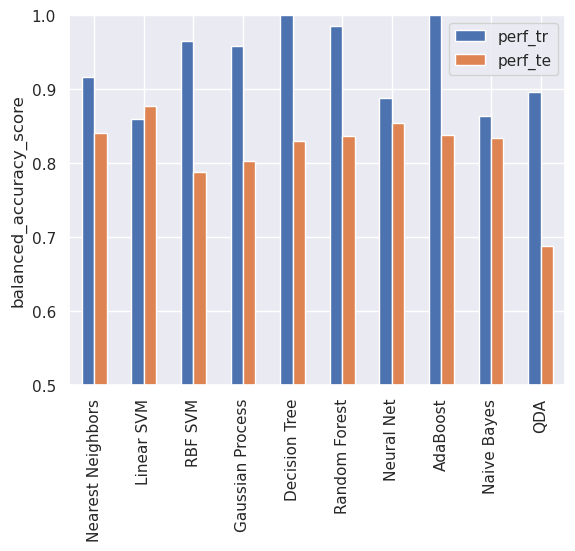

In [12]:
compar_results[['perf_tr', 'perf_te']].plot.bar()
plt.ylim(0.5, 1)
plt.ylabel(sklearn_metric.__name__);

##  Sous-apprentissage et surapprentissage

Lorsque l'on entraîne un classificateur sur des données, deux
comportements sont à éviter:

- Lorsque à la fois les performances d'entraînement `perf_tr` et les
  performances de test `perf_te` sont mauvaises, on dit alors que le
  classificateur a ***sous-appris*** (*under-fitting*).
- Lorsque les performances d'entraînement `perf_tr` sont bonnes mais
  les performances de test `perf_te` sont mauvaises, on dit alors que
  le classificateur a ***sur-appris*** (*over-fitting*).

Ces notions sont liés à la granularité de la frontière de décision,
qui peut être illustré par les graphiques suivants: 

<img class="fit-picture"
src="https://qph.fs.quoracdn.net/main-qimg-0d12f79a596c9b2ee1e23476fa3d44aa"
alt="Under-fitting, optimal and Over-fitting models">

Analysons quels classificateurs ont sur-appris resp. sous-appris. Pour
cela nous allons:
1. Identifier les classificateurs dont les performances de test sont
   inférieures à la performance de test médiane.
2. Parmi ceux-ci, nous dirons que les classificateurs dont la
   performance d'entraînement est **inférieure à la médiane** ont
   sous-appris, tandis que ceux dont la performance d'entraînement est
   **supérieure à la médiane** ont sur-appris.

In [13]:
analyze_model_experiments(compar_results)

,perf_tr,std_tr,perf_te,std_te,Overfitted,Underfitted
Nearest Neighbors,0.916964,0.027965,0.840179,0.066029,False,False
Linear SVM,0.859821,0.072542,0.877679,0.054756,False,False
RBF SVM,0.965179,0.034913,0.788393,0.090355,True,False
Gaussian Process,0.958036,0.046915,0.802679,0.096367,True,False
Decision Tree,1.000000,0.000000,0.829464,0.101444,True,False
Random Forest,0.985714,0.028571,0.836607,0.077843,False,False
Neural Net,0.888393,0.054931,0.854464,0.048421,False,False
AdaBoost,1.000000,0.000000,0.837500,0.088190,False,False
Naive Bayes,0.863393,0.068004,0.833929,0.044140,False,True
QDA,0.895536,0.116075,0.688393,0.122907,False,True


**Exercice:** Quelles sont les classificateurs qui ont sous-appris
resp. sur-appris ?

Les classificateur ayant sous-appris sont Naive Bayes et QDA tandis que ceux qui ont sur appris sont RBF SVM, Gaussian Process et Decision Tree

## Pour aller plus loin ♣: Comité de classificateurs et incertitude

Un comité de classificateurs est un classificateur dans lequel les
réponses de plusieurs classificateurs sont combinées en une seule
réponse. En d'autres termes, les classificateurs **votent** pour les
prédictions émises.

On pourrait considérer notre liste de classificateur `model_list`
comme un comité de classificateurs, entraînés sur les mêmes données
d'entraînement, et faisant des prédictions sur les mêmes données de
test. Regardez le code suivant; il est en réalité simple: on définit
les méthodes `fit`, `predict`, `predict_proba` et `score` comme
faisant la synthèse des résultats des classificateurs contenus dans
`self.model_list`.

In [14]:
class ClassifierCommittee():
    def __init__(self, model_list):
        self.model_list = model_list
        
    def fit(self,X,y):
        for model in self.model_list:
            model.fit(X,y)
    def predict(self,X):
        predictions = []
        for model in self.model_list:
            predictions.append(model.predict(X))
        predictions = np.mean(np.array(predictions),axis = 0)
        results = []
        for v in predictions:
            if v < 0:
                results.append(-1)
            else:
                results.append(1)
        return np.array(results)
    
    def predict_proba(self,X):
        predictions = []
        for model in self.model_list:
            predictions.append(model.predict_proba(X))
        return np.swapaxes(np.array(predictions), 0, 1)
    def score(self,X):
        scores = []
        for model in self.model_list:
            scores.append(model.score(X,y))
        return np.swapaxes(np.array(scores), 0, 1)

Quelles seraient les performances d'un tel classificateur?

In [15]:
commitee = ClassifierCommittee(model_list)

In [16]:
perf_tr, std_tr, perf_te, std_te = df_cross_validate(df_features, commitee, sklearn_metric)
print(perf_te, std_te)

0.8383928571428572 0.07767857142857143


La performance de l'ensemble de classificateurs n'est pas forcément
meilleure que les classificateurs pris individuellement. Cependant,
l'accord ou le désaccord des classificateurs sur les prédictions peut
nous donner des informations sur l'incertitude des données.

En effet, chaque classificateur peut émettre des probabilités sur les
classes avec la méthode `predict_proba`.  Pour quantifier
l'incertitude d'une image, on peut distinguer deux cas de figure :
- Les classificateurs du comité sont d'accord sur des probabilités
  incertaines (à gauche sur la figure) : chaque classificateur émet
  une probabilité proche de `[0.5, 0.5]`. On parle alors d'incertitude
  aléatorique, et elle est lié à l'**ambiguïté** intrinsèque de la
  tâche de classification.
- Les classificateurs du comité sont certains de leurs prédictions,
  mais ils sont en désaccord entre eux (à droite sur la figure) : les
  classificateurs émettent chacun une probabilité confiante mais
  différentes: `[1.,0.]`, `[0., 1.]`, `[0.9, 0.1]`, `[0.05, 0.95]`,
  etc. Dans ce cas on parle d'incertitude `épistémique`, et elle est
  lié à l'idée de **nouveauté** dans les données. Cette incertitude
  peut être réduite en ajoutant de nouvelles données.

<img class="fit-picture"
     src=media/aleatoric_epistemic.png
     alt="Under-fitting, optimal and Over-fitting models">
     

Intéressons nous aux images avec une faible incertitude épistémique
(les classificateurs sont d'accord) et une grande incertitude
aléatorique (les classificateurs sont incertains de la
prédiction). Cela correspond à des images se situant aux abords de la
frontière de décision entre nos deux catégories.

### Incertitude aléatorique

Nous allons utiliser l'[entropie de
Shannon](https://fr.wikipedia.org/wiki/Entropie_de_Shannon), qui est
une mesure en théorie de l'information permettant d'estimer la
quantité d'information contenu dans une source d'information (ici
notre probabilité sur les classes): 

$$H(X) = - \sum_{i=1}^{n}P(x_i)log_2(x_i)$$

où $x_i$ est la probabilité de classification sur la classe $i$.

On récupère alors les prédictions de nos images pour les 10
classificateurs :

In [17]:
X = df_features.iloc[:, :-1].to_numpy()
Y = df_features.iloc[:, -1].to_numpy()
commitee.fit(X, Y)
prediction_probabilities = commitee.predict_proba(X)

La dimension de notre matrice de prédiction est donc: `(nombre
d'images, nombre de classificateur, nombre de classess)`. Appliquons
l'entropie pour chaque prédiction de chaque classificateur :

In [18]:
from scipy.stats import entropy
entropies_per_classifier = entropy(np.swapaxes(prediction_probabilities, 0, 2))

On moyenne les entropies d'une image entre les classificateurs :

In [19]:
entropies = np.mean(entropies_per_classifier, axis = 0)

Puis on ajoute ces valeurs dans une table que l'on trie par ordre
décroissant d'entropie. Les images avec l'entropie la plus grande sont
les plus incertaines et donc les plus informatives pour le modèle :

In [20]:
df_uncertainty = pd.DataFrame({"images" : images,
                           "entropy" : entropies})
df_uncertainty = df_uncertainty.sort_values(by=['entropy'],ascending=False)

In [21]:
df_uncertainty.style.background_gradient(cmap='RdYlGn_r')

,images,entropy
b04.png,,0.522924
a01.png,,0.427582
a03.png,,0.384194
b09.png,,0.381119
a06.png,,0.380011
b06.png,,0.364715
b14.png,,0.363557
b01.png,,0.360231
b02.png,,0.338579
b03.png,,0.335534


Affichons les 10 images **les plus incertaines** pour le comité de
classificateurs, selon cette mesure aléatorique de l'incertitude. Ces
images nous donne une idée de l'ambiguité intrinsèque de notre base de
données.

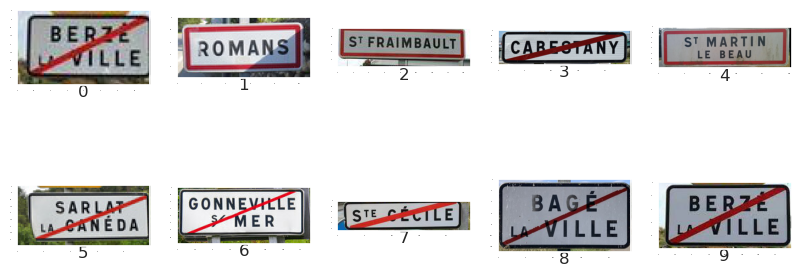

In [22]:
uncertain_aleatoric_images = df_uncertainty['images'].tolist()
image_grid(uncertain_aleatoric_images[:10])

Affichons maintenant les 10 images les **moins incertaines** pour
notre comité de classificateurs :

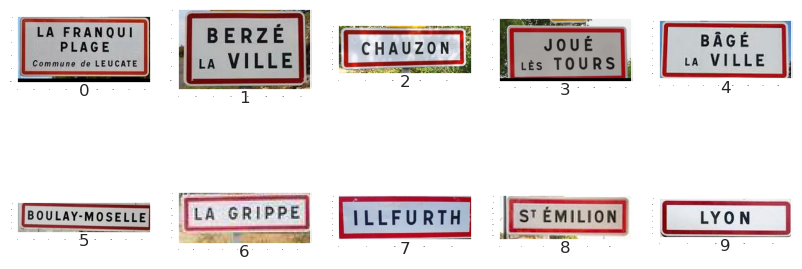

In [23]:
image_grid(uncertain_aleatoric_images[-10:])

**Exercice:** Ces résultats vous semblent-ils surprenants? Expliquer.

Ces résultats ne sont pas surprenants. En effet, les 10 images les plus incertaines sont assez sombres, ou possèdent des ombres ou encore sont penchés au millieu du panneau tandis que les 10 images les moins incertaines sont assez bien éclairées, sont bien cadrées

### Incertitude épistémique

Pour l'incertitude épistémique, on va simplement moyenner entre les
classificateurs les écarts types entre les classes :

In [24]:
# std entre les classses
epistemic_uncertainty = np.std(prediction_probabilities, axis = 2)
print(epistemic_uncertainty.shape)
# mean entre les classificateurs
epistemic_uncertainty = np.mean(epistemic_uncertainty, axis = 1)
print(epistemic_uncertainty.shape)

(30, 10)
(30,)


On ajoute cette mesure au tableau puis on classe les images par ordre
décroissant :

In [25]:
df_uncertainty["std_epistemic"] = epistemic_uncertainty
df_uncertainty = df_uncertainty.sort_values(by=['std_epistemic'],ascending=False)
df_uncertainty.style.background_gradient(cmap='RdYlGn_r')

,images,entropy,std_epistemic
a04.png,,0.254594,0.450688
b07.png,,0.324595,0.450600
b05.png,,0.330419,0.450197
b13.png,,0.276009,0.449601
b14.png,,0.363557,0.447430
b01.png,,0.360231,0.445677
a01.png,,0.427582,0.441109
a06.png,,0.380011,0.440539
b03.png,,0.335534,0.436506
b15.png,,0.261902,0.430366


In [26]:
df_uncertainty.corr()

,entropy,std_epistemic
entropy,1.000000,0.186451
std_epistemic,0.186451,1.000000


Les valeurs d'incertitude aléatorique (entropie) et épistémiques (std)
ne semblent pas très corrélées. Affichons les images les plus
incertaines selon cette mesure d'incertitude épistémique :

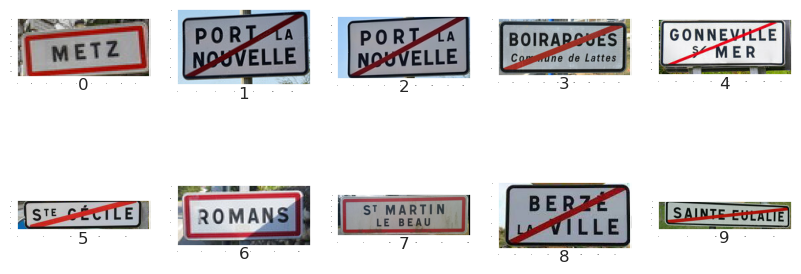

In [27]:
uncertain_epistemic_images = df_uncertainty['images'].tolist()
# les images où les classificateurs sont le moins d'accord
image_grid(uncertain_epistemic_images[:10])

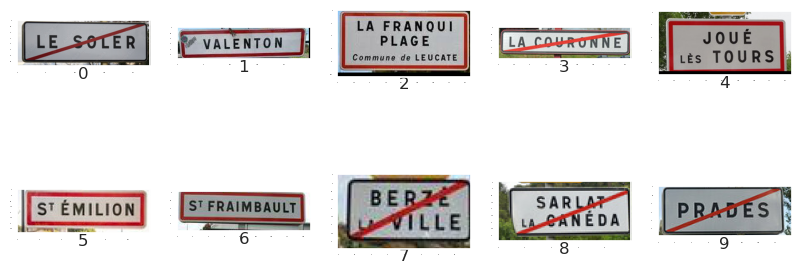

In [28]:
# les images où les classificateurs sont le plus d'accord
image_grid(uncertain_epistemic_images[-10:])

**Exercice:** Ces résultats vous semblent-ils surprenants? Expliquer.

Pour certaines images, c'est compréhensible puisque les panneaux sont plus ou moins bien orientés, mais pour d'autres images, il est difficile de comprendre pourquoi les classificateurs ne sont pas d'accord entre eux. Par exemple, les classificateurs ne sont pas d'accord entre eux pour la ville de Lyon alors que le panneau est bien orienté, bien croppé  et pas flou. Alors que les classificateurs se mettent facilement d'accord sur des panneaux qui ne sont pas sur des images parfaites, par exemple pour Metz, le panneau est penché sur la gauche, ce qui pourrait créer des conflits au niveau des classificateurs

## Pour aller plus loin ♣: apprentissage profond

En classe, vous apprendrez ce qu'est un ***réseau de neurones
artificiel*** et l'***apprentissage profond***. En résumé, il s'agit
de modèles (classificateurs par exemple) dont l'architecture est
articulée en «couches» composées de différentes transformations non
linéaires: des couches de neurones, des convolutions ou d'autres
transformations.

Des ***poids*** (paramètres appris par le réseau) sont associés aux
neurones et sont optimisés lors de l'entraînement sur les données par
une technique appelée ***descente de gradient***.  Quand le réseau
fait une prédiction, les valeurs des données brutes (pixels) sont
propagées dans le réseau jusqu'à donner le résultat en sortie. La
spécificité de ces architectures est qu'elles manipulent des données
brutes, sans utiliser d'attributs: les attributs sont en quelque sorte
appris par le réseau.

Pour mieux comprendre l'architecture connexioniste d'un réseau de
neurone profond, consultez [ce
site](https://www.cs.ryerson.ca/~aharley/vis/conv/) créé par Adam
Harley de l'Université Carnegie Mellon. Il présente un réseau
convolutionnel pour la reconnaissance de chiffres manuscrits. On peut
y dessiner des chiffres (en haut à gauche) et visualiser les
prédictions faites lors de la propagation des valeurs des pixels dans
le réseau. Passez votre souris sur un neurone et vous verrez ses
connexions avec les neurones des autres couches s'afficher.

Ces réseaux profonds comptent beaucoup de paramètres (neurones) à
optimiser. Ils nécessitent des infrastructures spéciales pour les
entraîner: de puissantes cartes graphiques (GPU), comme celles
utilisées pour les jeux vidéos, qui permettent de paralléliser les
calculs. Nous ne disposons pas de telles infrastructures sur le
service JupyterHub de l'université.

Nous allons donc voir comment transférer les connaissances apprises
par un réseau pour l'adapter à votre problème. On appelle cela
l'***apprentissage par transfert*** (*Transfer Learning*). Il nous
permet de partir d'un réseau de neurones déjà entraîné pour des tâches
similaires, et de n'avoir plus qu'à l'entraîner un peu plus pour notre
tâche spécifique.

### MobileNet et transfert

<div class="alert alert-info" role="alert">

La suite de cette feuille utilise les bibliothèques `tensorflow` et
`keras`. Celles-ci sont installées sur JupyterHub, mais pas forcément
ailleurs (elles sont assez volumineuses).

</div>

Nous allons utiliser un réseau pré-entraîné appelé `MobileNet`, dont
l'architecture a été optimisé pour fonctionner sur les téléphones
portables. Il a été pré-entraîné pour reconnaître mille catégories
différentes (dont des animaux, des objets de la vie courante etc.).

Depuis la librairie `keras`, importons le modèle pré-entraîné sur la
base de donnée `imagenet` :

In [29]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

mobilenet = tf.keras.applications.MobileNet(include_top=False, weights='imagenet', input_shape = (32,32,3))

2023-04-11 14:34:24.241083: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-04-11 14:34:25.794806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Observons l'architecture en couches de ce réseau de neurones; chaque
ligne ci-dessous décrit brièvement l'une des couches successives :

In [30]:
mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 16, 16, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 16, 16, 32)       128       
 ation)                                         

**Exercice:** Combien ce réseau a-t-il de paramètres? Parmi ces
paramètres, combien sont entraînables?

ce réseau possède 3 228 864 paramètre, dont 3 206 976 sont entrainables, ce qui correspond à une proportion de 99.3%

En déclarant le réseau avec le paramètre `include_top=False`, on a
retiré la dernière couche de neurone. **Le transfert d'apprentissage
va pouvoir être fait en ajoutant des nouvelles couches de neurones
entraînables à la fin de ce réseau pré-entraîné (dont les paramètres
vont être gelés).** Ainsi, on pourra entraîner seulement les dernières
couches de notre réseau sans avoir à réentraîner tout le réseau, ce
qui nécessiterait autrement une puissante carte graphique. En d'autres
termes, le réseau `mobilenet` va nous donner des attributs abstraits
sur lesquels nous allons réentraîner un nouveau réseau de neurones,
plus petit.

On commence par geler les poids du réseau `mobilenet` :

In [31]:
for layer in mobilenet.layers:
    layer.trainable=False

Vérifiez que tous les paramètres de `mobilenet` sont à présent
non-entraînables :

In [32]:
mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 16, 16, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 16, 16, 32)       128       
 ation)                                         

On va à présent ajouter de nouvelles couches entraînables de neurones :

In [33]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D

myneuralnet = keras.Sequential(
    [
        mobilenet,
        GlobalAveragePooling2D(),
        Dense(64, activation="relu", name="layer1"),
        Dense(64, activation="relu", name="layer2"),
        Dense(2, activation="softmax",name="layer3"),
    ]
)

Configurons le réseau `mobilenet` pour prendre en entrée des images de
taille `(32,32,3)`:

In [34]:
myneuralnet.build((None,32,32,3))
myneuralnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 layer1 (Dense)              (None, 64)                65600     
                                                                 
 layer2 (Dense)              (None, 64)                4160      
                                                                 
 layer3 (Dense)              (None, 2)                 130       
                                                                 
Total params: 3,298,754
Trainable params: 69,890
Non-tra

**Exercice**: À présent combien ce réseau a-t-il de paramètres? Parmi
ces paramètres, combien sont entraînables?

ce réseau possède 3 298 754 paramètres, dont 69 890 sont entrainables

 Chargeons nos données recentrées et recadrées de taille 32x32 :

In [35]:
df_clean = pd.read_csv('clean_data.csv', index_col=0)  # chargement du fichier dans le notebook
#df_clean=df_clean.drop([str(i) for i in range(35000,93600)],axis=1)
#df_clean[:1].describe()

In [38]:
df_clean[Index=1]

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (760682693.py, line 1)

On souhaite avoir une variable `X` de type `np.ndarray` de taille
`(491, 32, 32, 3)` c'est à dire `(nombre d'images, largeur, hauteur,
nombre de couches de couleurs)` :

In [ ]:
X = np.array(df_clean.drop(['class'], axis=1)).reshape((491, 32, 32, 3))

Il est nécessaire d'encoder les étiquettes sous la forme d'un *one-hot
vector* c'est-à-dire d'un tableau `y_onehot` de taille `(nombre
d'images, nombre de classes)` tel que `y_onehot[i,j]==1` si la i-ème
étiquette est la j-ème classe et `0` sinon. Dans notre cas, la i-ème
ligne vaut `(1,0)` si le i-ème fruit est une pomme, et `(0,1)` si
c'est une banane :

In [ ]:
y = np.array(df_clean["class"])
classes = np.unique(y)
class_to_class_number = { cls: number for number, cls in enumerate(classes) }
y_onehot = np.zeros((len(y), len(np.unique(y))))
for i, label in enumerate(y):
    y_onehot[i, class_to_class_number[label]] = 1

On doit maintenant définir l'***optimisateur*** et la ***fonction de
coût*** qui vont permettre d'optimiser les paramètres de nos
neurones. Les poids des neurones vont être optimisés pour ***minimiser
la fonction de coût*** (*loss*) :

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)
myneuralnet.compile(loss='categorical_crossentropy', metrics=["accuracy"], optimizer=opt)

Avant de pouvoir entraîner notre réseau, on va d'abord diviser nos
données en deux: les données d'entraînement et les données de test :

In [ ]:
test = np.array(y == 1, dtype = int)
X_train = np.concatenate((X[:165], X[333:333+ 79]), axis = 0)
y_train = np.concatenate((y_onehot[:165], y_onehot[333:333+ 79]), axis = 0)

X_test = np.concatenate((X[165:333], X[333+ 79:]), axis = 0)
y_test = np.concatenate((y_onehot[165:333], y_onehot[333+ 79:]), axis = 0)

On peut finalement entraîner notre réseau de neurone !  

**Attention :** Le temps de calcul étant potentiellement élevé, la
cellule ci-dessous est désactivée par défaut. Mettez en commentaire la
première ligne pour lancer le calcul.

In [ ]:
#%%script echo cellule désactivée

from sklearn.model_selection import StratifiedKFold
import pdb
stop = pdb.set_trace
def create_model():
    myneuralnet = keras.Sequential(
    [
        mobilenet,
        GlobalAveragePooling2D(),
        Dense(64, activation="relu", name="layer1"),
        Dense(64, activation="relu", name="layer2"),
        Dense(2, activation="softmax",name="layer3"),
    ])
    myneuralnet.build((None,32,32,3))
    opt = keras.optimizers.Adam(learning_rate=0.01)
    myneuralnet.compile(loss='categorical_crossentropy', metrics=["accuracy"], optimizer=opt)
    return myneuralnet

def train_evaluate(model, x_train, y_train, x_test, y_test):
    history = model.fit(x_train, y_train, epochs = 10, shuffle = True)
    return model.evaluate(x_test, y_test)

kFold = StratifiedKFold(n_splits=10)
scores = np.zeros(10)
idx = 0
for train, test in kFold.split(X, y):
    model = create_model()
    scores[idx] = train_evaluate(model, X[train], y_onehot[train], X[test], y_onehot[test])[1]
    idx += 1
print(scores)
print(scores.mean())

Afficher les valeurs d'accuracy au fur et à mesure des itérations
d'optimisations :

In [ ]:
#%%script echo cellule désactivée

plt.plot(scores)
plt.xlabel("Nombre d'itération d'optimisations")
plt.ylabel("Accuracy")

## Conclusion

Cette feuille a fait un tour d'horizon d'outils de classification à
votre disposition. Prenez ici quelques notes sur ce que vous avez
appris, observé, interprété.

Nous avons pu s'approprier le concept de sous-entrainement, sur-entrainement, les modèles épistémiques et aléatoriques.

Itérez sur le prétraitement, l'extraction d'attributs et la
classification de vos images dans les feuilles respectives pour
améliorer votre classification, puis préparez votre diaporama!